# Scenario - Credit Card Approval

In [2]:
import os
import sys
from sklearn.metrics import accuracy_score
sys.path.insert(1, "../")
try:
    from helpers import save_solution
except Exception as e:
    print(e)

In [3]:
from factsheet import Factsheet
factsheet = Factsheet()

factsheet.set_question_fairness(3)
factsheet.set_protected_feature("Group")
factsheet.set_protected_group("lambda x: x[protected_feature] == 1")
factsheet.set_target_column("Target")
factsheet.set_favorable_outcome("lambda x: x[target_column] == 1")

In [4]:
# Load all necessary packages
#import os
#import sys
#sys.path.insert(1, "../")  
  
import numpy as np
np.random.seed(0)

import matplotlib.pyplot as plt

import pandas as pd
import sklearn
import pickle
from aif360.datasets import GermanDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from IPython.display import Markdown, display

In [5]:
data = pd.read_csv("./data/data.csv", nrows=60000)
data.head(5)

,Num_Children,Group,Income,Own_Car,Own_Housing,Target
0,4,0,36151,0,0,0
1,0,0,36095,1,0,0
2,2,1,62110,1,1,0
3,0,1,73644,1,0,0
4,3,0,99146,0,0,1


In [6]:
print("Number of samples: {}".format(len(data)))

Number of samples: 60000


In [7]:
target_column = "Target"

In [8]:
X = data.loc[:, data.columns != target_column]
X.head(5)

,Num_Children,Group,Income,Own_Car,Own_Housing
0,4,0,36151,0,0
1,0,0,36095,1,0
2,2,1,62110,1,1
3,0,1,73644,1,0
4,3,0,99146,0,0


In [9]:
y = data.loc[:, data.columns == target_column]
y.head(5)

,Target
0,0
1,0
2,0
3,0
4,1


In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

### Statistical Parity Difference

In [137]:
import operator

target_column = "Target"
favorable_outome = lambda x: x[target_column]==1

protected_feature = "Group"
protected = lambda x: x[protected_feature]==0
protected_indices = data.apply(protected, axis=1)

In [ ]:
minority = data[protected_indices]
minority_size = len(minority)
favored_minority = minority[minority.apply(favorable_outome, axis=1)]
favored_minority_size = len(favored_minority)
favored_minority_ratio = favored_minority_size/minority_size
print("{0}/{1} = {2}".format(favored_minority_size, minority_size, favored_minority_ratio))

In [ ]:
majority = data[~protected_indices]
majority_size = len(majority)
favored_majority = majority[majority.apply(favorable_outome, axis=1)]
favored_majority_size = len(favored_majority)
favored_majority_ratio = favored_majority_size/majority_size
print("{0}/{1} = {2}".format(favored_majority_size, majority_size, favored_majority_ratio))

In [ ]:
statistical_parity_difference = favored_minority_ratio - favored_majority_ratio
print(statistical_parity_difference)

### 1. SVM

In [ ]:
from sklearn import svm
support_vector_machine_01 = svm.SVC(verbose=1, probability=True)
support_vector_machine_01.fit(X_train, y_train.values.ravel())

In [ ]:
y_pred = support_vector_machine_01.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

In [48]:
save_solution("credit_card_approval", "jans_support_vector_machine_01", support_vector_machine_01, train_data, test_data, factsheet, to_webapp=True)

base directory /Users/jankreischer/Desktop/Masterproject/Shared/scenarios/credit_card_approval/../../webapp/scenarios/credit_card_approval/solutions/jans_support_vector_machine_01


In [49]:
support_vector_machine_02 = svm.SVC(verbose=1, probability=True)
support_vector_machine_02.fit(X_train, y_train.values.ravel())

[LibSVM].......
*
optimization finished, #iter = 7891
obj = -7503.632622, rho = -1.419943
nSV = 7538, nBSV = 7536
Total nSV = 7538
.......
*.
*
optimization finished, #iter = 7794
obj = -7449.764649, rho = -2.206482
nSV = 7488, nBSV = 7486
Total nSV = 7488
.......
*
optimization finished, #iter = 7736
obj = -7458.689983, rho = -2.368770
nSV = 7498, nBSV = 7496
Total nSV = 7498
.......
*
optimization finished, #iter = 7807
obj = -7472.208202, rho = -1.615098
nSV = 7506, nBSV = 7503
Total nSV = 7506
.......
**.
*
optimization finished, #iter = 7966
obj = -7455.821821, rho = -1.653242
nSV = 7490, nBSV = 7488
Total nSV = 7490
.........
*
optimization finished, #iter = 9622
obj = -9326.399502, rho = 2.318357
nSV = 9366, nBSV = 9364
Total nSV = 9366


SVC(probability=True, verbose=1)

In [44]:
save_solution("credit_card_approval", "jans_support_vector_machine_02", support_vector_machine_02, train_data, test_data, factsheet, to_webapp=True)

base directory /Users/jankreischer/Desktop/Masterproject/Shared/scenarios/credit_card_approval/../../webapp/scenarios/credit_card_approval/solutions/jans_support_vector_machine_02


### 2. k-Nearest Neighbors

In [11]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X_train, y_train.values.ravel());

In [12]:
y_pred = clf.predict(X_test)

In [13]:
print(confusion_matrix(y_test,y_pred))

[[6667  594]
 [ 594 4145]]


In [14]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      7261
           1       0.87      0.87      0.87      4739

    accuracy                           0.90     12000
   macro avg       0.90      0.90      0.90     12000
weighted avg       0.90      0.90      0.90     12000



In [15]:
error_rate = []

for i in range(1,11):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train.values.ravel())
    y_pred = knn.predict(X_test)
    error_rate.append(np.mean(y_pred != y_test.values.ravel()))

Text(0, 0.5, 'Error Rate')

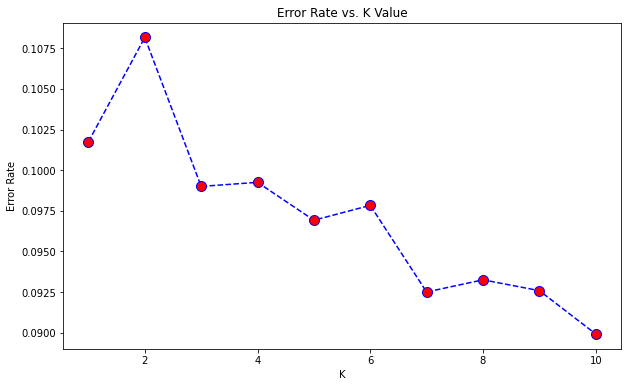

In [15]:
plt.figure(figsize=(10,6))
plt.plot(range(1,11),error_rate,color='blue', linestyle='dashed', marker='o',
 markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [16]:
# NOW WITH K=20
clf_knn_01 = KNeighborsClassifier(n_neighbors=20)
clf_knn_01.fit(X_train,y_train.values.ravel())
pred = clf_knn_01.predict(X_test)

print(confusion_matrix(y_test,pred))

print(classification_report(y_test,pred))

[[6804  457]
 [ 616 4123]]
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      7261
           1       0.90      0.87      0.88      4739

    accuracy                           0.91     12000
   macro avg       0.91      0.90      0.91     12000
weighted avg       0.91      0.91      0.91     12000



In [14]:
save_solution("credit_card_approval", "jans_knn_classifier_01", clf_knn_01, train_data, test_data, factsheet, to_webapp=True)

base directory /Users/jankreischer/Desktop/Masterproject/Shared/scenarios/credit_card_approval/../../webapp/scenarios/credit_card_approval/solutions/jans_knn_classifier_01


### Equal Opportunity Difference

 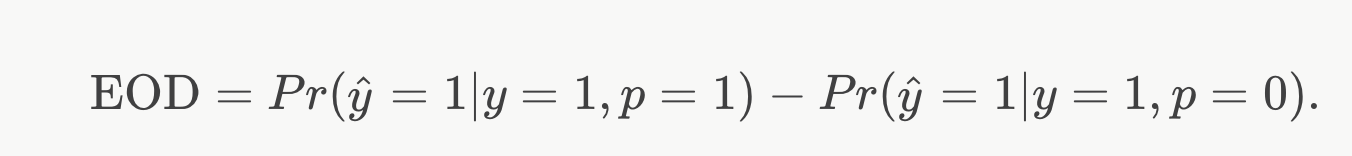

In [ ]:
y_pred = clf_knn_01.predict(X_test)

In [ ]:
data = X_test.copy(deep=True)

In [ ]:
data['y_pred'] = y_pred.tolist()

In [ ]:
data['y_true'] = y_test["Target"].tolist()

In [200]:
import operator
target_column = 'y_true'
favorable_outome = lambda x: x[target_column]==1
#target_column = 'y_pred'
#favorable_prediction = lambda x: x[target_column]==1

protected_feature = "Group"
protected = lambda x: x[protected_feature]==0


In [201]:
favored_indices = data.apply(favorable_outome, axis=1)
protected_indices = data.apply(protected, axis=1)

In [202]:
favored_samples = data[favored_indices]
protected_favored_samples = favored_samples[protected_indices]
unprotected_favored_samples = favored_samples[~protected_indices]

Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.


In [203]:
num_unprotected_favored_true = len(unprotected_favored_samples)
target_column = 'y_pred'
num_unprotected_favored_pred = len(unprotected_favored_samples[unprotected_favored_samples.apply(favorable_prediction, axis=1)])
unprotected_favored_ratio = num_unprotected_favored_pred/num_unprotected_favored_true
print("unprotected_favored_ratio: {}".format(unprotected_favored_ratio))

unprotected_favored_ratio: 0.8353956834532374


In [204]:
num_protected_favored_true = len(protected_favored_samples)
target_column = 'y_pred'
num_protected_favored_pred = len(protected_favored_samples[protected_favored_samples.apply(favorable_prediction, axis=1)])
protected_favored_ratio = num_protected_favored_pred / num_protected_favored_true 
print("protected_favored_ratio: {}".format(protected_favored_ratio))

protected_favored_ratio: 0.9651898734177216


In [ ]:
equal_opportunity_difference = protected_favored_ratio - unprotected_favored_ratio
print("equal_opportunity_difference: {}".format(equal_opportunity_difference))

equal_opportunity_difference: 0.1297941899644841


### Average Odds Difference
Is the average of difference in false positive rates and true positive rates between the protected and unprotected group

In [251]:
y_pred = clf_knn_01.predict(X_test)

data = X_test.copy(deep=True)

data['y_pred'] = y_pred.tolist()

data['y_true'] = y_test["Target"].tolist()

import operator
import funcy

# Calculate FPR means y_pred = fav and y_true = unfav
# Is the number of evens which wrongly have y_pred=True but y_true=False and the total number of negative samples with y_true=False

#is_odd = funcy.compose(operator.not_, is_even)

target_column = 'y_true'
favorable_outcome = lambda x: x[target_column]==1
unfavorable_outcome = funcy.compose(operator.not_, favorable_outcome)


favorable_prediction = lambda x: x['y_pred']==1
unfavorable_prediction = funcy.compose(operator.not_, favorable_prediction)

protected_feature = "Group"
protected_group_definition = lambda x: x[protected_feature]==0


#n_unfavorable = len(data[data.apply(unfavorable_outcome, axis=1)])
#print("n_true_unfavorable {}".format(n_unfavorable))

#1. Divide into protected and unprotected group
protected_indices = data.apply(protected_group_definition, axis=1)
protected_group = data[protected_indices]
unprotected_group = data[~protected_indices]

#2. Compute the number of negative samples y_true=False for the protected and unprotected group.
protected_group_true_unfavorable = protected_group[protected_group.apply(unfavorable_outcome, axis=1)]
unprotected_group_true_unfavorable = unprotected_group[unprotected_group.apply(unfavorable_outcome, axis=1)]
protected_group_n_true_unfavorable = len(protected_group_true_unfavorable)
unprotected_group_n_true_unfavorable = len(unprotected_group_true_unfavorable)
print("protected_group_n_true_unfavorable {}".format(protected_group_n_true_unfavorable))
print("unprotected_group_true_unfavorable {}".format(unprotected_group_true_unfavorable))

#3. Calculate the number of false positives for the protected and unprotected group
protected_group_true_unfavorable_pred_favorable = protected_group_true_unfavorable[protected_group_true_unfavorable.apply(favorable_prediction, axis=1)]
unprotected_group_true_unfavorable_pred_favorable = unprotected_group_true_unfavorable[unprotected_group_true_unfavorable.apply(favorable_prediction, axis=1)]
protected_group_n_true_unfavorable_pred_favorable = len(protected_group_true_unfavorable_pred_favorable)
unprotected_group_n_true_unfavorable_pred_favorable = len(unprotected_group_true_unfavorable_pred_favorable)

#4. Calculate fpr for both groups.
protected_fpr = protected_group_n_true_unfavorable_pred_favorable/protected_group_n_true_unfavorable
unprotected_fpr = unprotected_group_n_true_unfavorable_pred_favorable/unprotected_group_n_true_unfavorable
print("protected_fpr: {}".format(protected_fpr))
print("unprotected_fpr: {}".format(unprotected_fpr))

### Disparate Impact

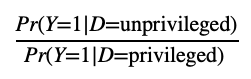

Is the ratio of people from the protected group who receive a favorable outcome divided by the ratio of people from the unprotected group receiving a favorable outcome
1. Let the model predict y_pred
2. Divide into protected and unprotected group
3. Compute for the protected and unprotected group the percentage of observations receiving a favorable outcome

In [28]:
import operator
import funcy

y_pred = clf_knn_01.predict(X_test)

data = X_test.copy(deep=True)

data['y_pred'] = y_pred.tolist()

target_column = 'y_true'
favorable_outcome = lambda x: x[target_column]==1
unfavorable_outcome = funcy.compose(operator.not_, favorable_outcome)

favorable_prediction = lambda x: x['y_pred']==1
unfavorable_prediction = funcy.compose(operator.not_, favorable_prediction)

protected_feature = "Group"
protected_group_definition = lambda x: x[protected_feature]==0


#n_unfavorable = len(data[data.apply(unfavorable_outcome, axis=1)])
#print("n_true_unfavorable {}".format(n_unfavorable))

#1. Divide into protected and unprotected group
protected_indices = data.apply(protected_group_definition, axis=1)
protected_group = data[protected_indices]
unprotected_group = data[~protected_indices]

protected_group_size = len(protected_group)
print("protected_group_size: {}".format(protected_group_size))
unprotected_group_size = len(unprotected_group)
print("unprotected_group_size: {}".format(unprotected_group_size))

protected_favored_group = protected_group[protected_group.apply(favorable_prediction, axis=1)]
unprotected_favored_group = unprotected_group[unprotected_group.apply(favorable_prediction, axis=1)]

protected_favored_group_size = len(protected_favored_group)
print("protected_group_size: {}".format(protected_favored_group_size))
unprotected_favored_group_size = len(unprotected_favored_group)
print("unprotected_group_size: {}".format(unprotected_favored_group_size))

protected_favored_ratio = protected_favored_group_size / protected_group_size
print("protected_favored_ratio: {}".format(protected_favored_ratio))
unprotected_favored_ratio = unprotected_favored_group_size / unprotected_group_size
print("unprotected_favored_ratio: {}".format(unprotected_favored_ratio))

disparate_impact = protected_favored_ratio / unprotected_favored_ratio
print("disparate_impact: {}".format(disparate_impact))

protected_group_size: 5979
unprotected_group_size: 6021
protected_group_size: 1668
unprotected_group_size: 2912
protected_favored_ratio: 0.2789764174611139
unprotected_favored_ratio: 0.4836405912639096
disparate_impact: 0.5768258961309639


### Testing Lambda Expressions

In [33]:
var = 3
inc_by_one = eval("lambda x: x+var")
numbers = [1,2,3,4]
result = list(map(inc_by_one, numbers))
print(result)

[4, 5, 6, 7]


In [185]:
import inspect

protected_feature = "Group"
protected = "lambda x: x[protected_feature]==1"
print(protected)
protected = eval(protected, {"protected_feature": protected_feature})
print(protected)

lambda x: x[protected_feature]==1
<function <lambda> at 0x7fc865aead30>


In [186]:
minority = data[data.apply(protected, axis=1)]

In [187]:
minority.head(5)

,Num_Children,Group,Income,Own_Car,Own_Housing,Target
2,2,1,62110,1,1,0
3,0,1,73644,1,0,0
5,0,1,114086,1,0,1
7,2,1,83130,1,1,1
8,2,1,81965,1,0,1


In [19]:
factsheet = {
    "general": {}
}
factsheet["general"]["target_column"] = "target"
print(factsheet)


{'general': {'target_column': 'target'}}


In [21]:
keys = ["general", "target_column"]

for key in key 
factsheet.get(key)

TypeError: unhashable type: 'list'

In [24]:
question_fairness = 0
question_fairness in list(range(1,5))

False

### 3. Random Forest Classifier

In [25]:
from sklearn.ensemble import RandomForestClassifier

In [26]:
random_forest_classifier_01 = RandomForestClassifier(max_depth=2, random_state=0)
random_forest_classifier_01.fit(X_train, y_train.values.ravel())

RandomForestClassifier(max_depth=2, random_state=0)

In [27]:
acc = random_forest_classifier_01.score(X_test, y_test.values.ravel())
print(acc)

0.9405833333333333


In [28]:
save_solution("credit_card_approval", "jans_random_forest_classifier_01", random_forest_classifier_01, train_data, test_data, factsheet, to_webapp=True)

base directory /Users/jankreischer/Desktop/Masterproject/Shared/scenarios/credit_card_approval/../../webapp/scenarios/credit_card_approval/solutions/jans_random_forest_classifier_01


In [29]:
random_forest_classifier_02 = RandomForestClassifier(max_depth=5, random_state=0)
random_forest_classifier_02.fit(X_train, y_train.values.ravel())

RandomForestClassifier(max_depth=5, random_state=0)

In [30]:
acc = random_forest_classifier_02.score(X_test, y_test.values.ravel())
print(acc)

0.9700833333333333


In [31]:
save_solution("credit_card_approval", "jans_random_forest_classifier_02", random_forest_classifier_02, train_data, test_data, factsheet, to_webapp=True)

base directory /Users/jankreischer/Desktop/Masterproject/Shared/scenarios/credit_card_approval/../../webapp/scenarios/credit_card_approval/solutions/jans_random_forest_classifier_02


In [30]:
print(type(np.nan))

<class 'float'>
